In [1]:
import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")


All done


In [3]:
Path_data = './re_eye_dataset'
data = os.listdir(Path_data)
Healthy = os.listdir('./re_eye_dataset/Healthy')
Mild = os.listdir('./re_eye_dataset/Mild DR')
Moderate = os.listdir('./re_eye_dataset/Moderate DR')
Proliferate = os.listdir('./re_eye_dataset/Proliferate DR')
Severe = os.listdir('./re_eye_dataset/Severe DR')

In [4]:
print("classes names :", (data), "\n______________________________\n")
print("Number of classes :", len(data), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")

classes names : ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR'] 
______________________________

Number of classes : 5 
______________________________

Number of Healty images : 1000 
______________________________

Number of Mild images : 370 
______________________________

Number of Moderate images : 900 
______________________________

Number of Proliferate images : 290 
______________________________

Number of severe images : 190 
______________________________



In [5]:
# Get Paths

Path_data = './re_eye_dataset'

# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directory to list

data = os.listdir(Path_data)

# Get paths and Labels of classes and images in data 

for i in data:
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)
    
    for img in imglist:
        imgpath = os.path.join(classpath, img)
        
        imgpaths.append(imgpath)
        labels.append(i)


# Convert two lists of imgpaths and their labels into series

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

Df= pd.concat([Paths, Labels], axis = 1)
Df.head(5)

,Paths,Labels
0,./re_eye_dataset\Healthy\Healthy.png,Healthy
1,./re_eye_dataset\Healthy\Healthy_10.png,Healthy
2,./re_eye_dataset\Healthy\Healthy_100.png,Healthy
3,./re_eye_dataset\Healthy\Healthy_1000.png,Healthy
4,./re_eye_dataset\Healthy\Healthy_101.png,Healthy


In [6]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


Labels
Healthy           805
Moderate DR       723
Mild DR           291
Proliferate DR    230
Severe DR         151
Name: count, dtype: int64

In [7]:
batch_size = 20   # As smaller, As more data generated ....In views of data size 
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


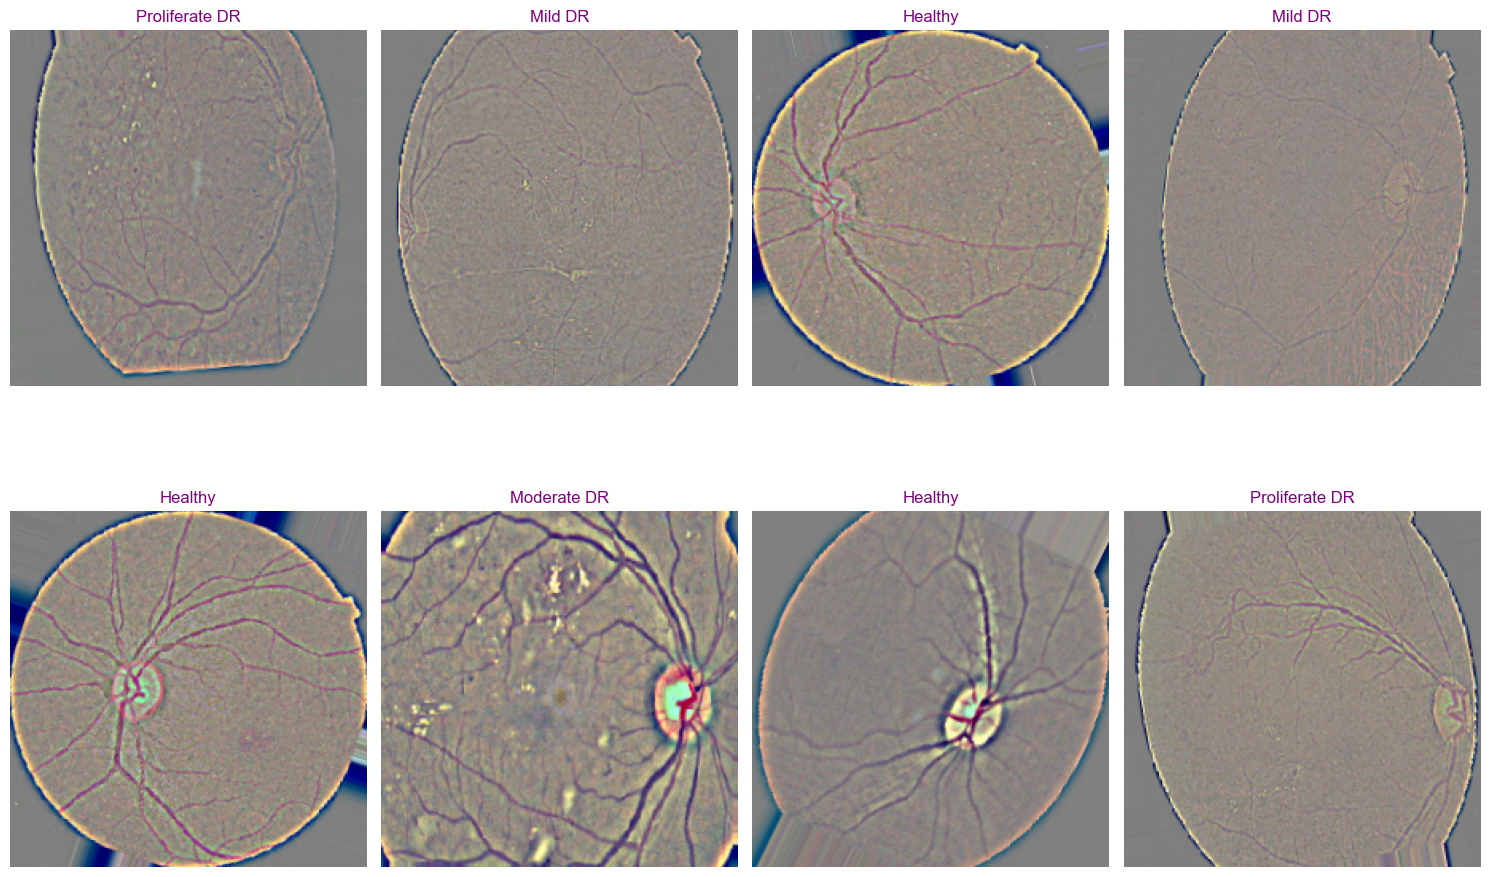

In [8]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)
    
    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')
    
plt.tight_layout()    
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

Epoch 46/50
110/110 [==============================] - 100s 903ms/step - loss: 1.4662 - accuracy: 0.3659 - val_loss: 1.4898 - val_accuracy: 0.3745
Epoch 47/50
110/110 [==============================] - 97s 871ms/step - loss: 1.4647 - accuracy: 0.3659 - val_loss: 1.4887 - val_accuracy: 0.3745
Epoch 48/50
110/110 [==============================] - 94s 852ms/step - loss: 1.4631 - accuracy: 0.3659 - val_loss: 1.4875 - val_accuracy: 0.3745
Epoch 49/50
110/110 [==============================] - 94s 851ms/step - loss: 1.4616 - accuracy: 0.3659 - val_loss: 1.4865 - val_accuracy: 0.3745
Epoch 50/50
110/110 [==============================] - 93s 845ms/step - loss: 1.7604 - accuracy: 0.3636 - val_loss: 1.4870 - val_accuracy: 0.3636


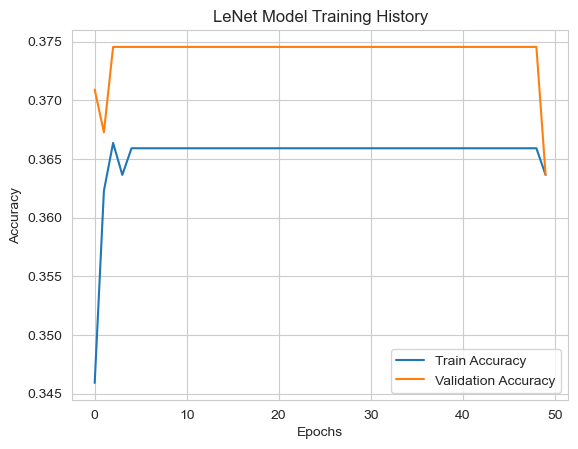

In [9]:
# LeNet Model
lenet_model = Sequential()

# First Convolutional Layer
lenet_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=img_shape))
lenet_model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
lenet_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
lenet_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
lenet_model.add(Flatten())

# Fully Connected Layers
lenet_model.add(Dense(128, activation='relu'))
lenet_model.add(Dropout(0.5))  # Adding dropout for regularization
lenet_model.add(Dense(5, activation='softmax'))  # Output layer with 5 classes

# Compile the model
lenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
lenet_model.summary()

# Train the model
lenet_epochs = 50
lenet_history = lenet_model.fit(
    Train,
    epochs=lenet_epochs,
    validation_data=Valid,
    shuffle=True
)

# Plot training history
plt.plot(lenet_history.history['accuracy'], label='Train Accuracy')
plt.plot(lenet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LeNet Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


14/14 [==============================] - 4s 263ms/step


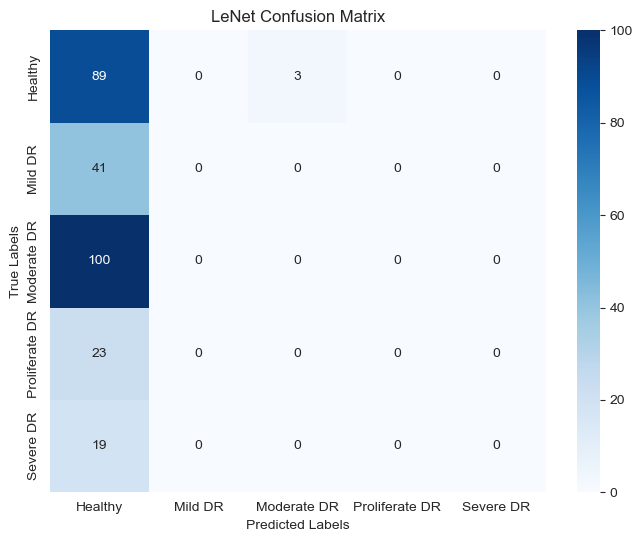

LeNet Classification Report:
                precision    recall  f1-score   support

       Healthy       0.33      0.97      0.49        92
       Mild DR       0.00      0.00      0.00        41
   Moderate DR       0.00      0.00      0.00       100
Proliferate DR       0.00      0.00      0.00        23
     Severe DR       0.00      0.00      0.00        19

      accuracy                           0.32       275
     macro avg       0.07      0.19      0.10       275
  weighted avg       0.11      0.32      0.16       275



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predictions
y_true_lenet = Test.classes
y_pred_lenet = np.argmax(lenet_model.predict(Test), axis=1)

# Confusion Matrix
cm_lenet = confusion_matrix(y_true_lenet, y_pred_lenet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lenet, annot=True, fmt='d', cmap='Blues', xticklabels=Keys, yticklabels=Keys)
plt.title('LeNet Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print("LeNet Classification Report:")
print(classification_report(y_true_lenet, y_pred_lenet, target_names=Keys))


In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load pre-trained ResNet50V2 model
resnet_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in resnet_base.layers:
    layer.trainable = False

# Create a new model on top
resnet_model = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Multiclass classification (5 classes)
])

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
resnet_model.summary()

# Set up callbacks
checkpoint = ModelCheckpoint("resnet_model.h5", monitor='val_loss', mode='min', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
resnet_history = resnet_model.fit(
    Train,
    epochs=50,
    validation_data=Valid,
    callbacks=[checkpoint, early_stopping],
    shuffle=True
)

# Evaluate on test set
resnet_eval = resnet_model.evaluate(Test, verbose=1)
print(f"ResNet Test Loss: {resnet_eval[0]:.4f}")
print(f"ResNet Test Accuracy: {resnet_eval[1] * 100:.2f}%")

# Predictions
y_true_resnet = np.argmax(Test.labels, axis=1)
y_pred_resnet = np.argmax(resnet_model.predict(Test), axis=1)

# Confusion Matrix
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
print("Confusion Matrix:")
print(cm_resnet)

# Classification Report
class_report_resnet = classification_report(y_true_resnet, y_pred_resnet, target_names=Keys)
print("Classification Report:")
print(class_report_resnet)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 24090629 (91.90 MB)
Trainable params: 525829 (2.01 MB)
Non-trainable params: 23564800 (89.89 MB)
_________

Epoch 25/50
110/110 [==============================] - ETA: 0s - loss: 1.2161 - accuracy: 0.5564
Epoch 25: val_loss improved from 1.37975 to 1.36535, saving model to resnet_model.h5
110/110 [==============================] - 265s 2s/step - loss: 1.2161 - accuracy: 0.5564 - val_loss: 1.3653 - val_accuracy: 0.5818
Epoch 26/50
110/110 [==============================] - ETA: 0s - loss: 1.1944 - accuracy: 0.5491
Epoch 26: val_loss did not improve from 1.36535
110/110 [==============================] - 265s 2s/step - loss: 1.1944 - accuracy: 0.5491 - val_loss: 1.3722 - val_accuracy: 0.5818
Epoch 27/50
110/110 [==============================] - ETA: 0s - loss: 1.1931 - accuracy: 0.5573
Epoch 27: val_loss improved from 1.36535 to 1.31789, saving model to resnet_model.h5
110/110 [==============================] - 264s 2s/step - loss: 1.1931 - accuracy: 0.5573 - val_loss: 1.3179 - val_accuracy: 0.5673
Epoch 28/50
 18/110 [===>..........................] - ETA: 3:18 - loss: 1.1668 - accuracy: 0.5